In [57]:
library(tidyverse)

library(rsample)
library(caret)
library(h2o)

### h2o set-up

In [58]:
h2o.no_progress() # h2o 진행률 표시줄 끄기
h2o.init()         # launch h2o

 Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         1 hours 2 minutes 
    H2O cluster timezone:       Asia/Seoul 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.36.0.4 
    H2O cluster version age:    6 days  
    H2O cluster name:           H2O_started_from_R_apf_temp_admin_eyz493 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   0.74 GB 
    H2O cluster total cores:    4 
    H2O cluster allowed cores:  4 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    R Version:                  R version 4.1.3 (2022-03-10) 



### R 데이터 프레임을 H2O 객체로 변환(즉, H2O 클라우드로 가져오기)

```
as.h2o(<my-data-frame>)
```

In [59]:
ames <- AmesHousing::make_ames()
ames.h2o <- as.h2o(ames)

### 데이터 분할

### 랜덤 샘플

#### 1. 기본 R

In [60]:
set.seed(123) 
index_1 <- sample(1:nrow(ames), round(nrow(ames) * 0.7))
train_1 <- ames[index_1, ]
test_1  <- ames[-index_1, ]

dim(train_1) ; dim(test_1)

[1] 2051   81

[1] 879  81

#### 2. caret 패키지

In [61]:
set.seed(123)  
index_2 <- createDataPartition(ames$Sale_Price, p = 0.7, 
                               list = FALSE)
train_2 <- ames[index_2, ]
test_2  <- ames[-index_2, ]

dim(train_2) ; dim(test_2)

[1] 2053   81

[1] 877  81

#### 3. rsample 패키지

In [62]:
set.seed(123)
split_1  <- initial_split(ames, prop = 0.7)
train_3  <- training(split_1)
test_3   <- testing(split_1)

dim(train_3) ; dim(test_3)

[1] 2051   81

[1] 879  81

#### 4. h2o 패키지

In [63]:
split_2 <- h2o.splitFrame(ames.h2o, ratios = 0.7, 
                          seed = 123)
train_4 <- split_2[[1]]
test_4  <- split_2[[2]]

dim(train_4) ; dim(test_4)

[1] 2053   81

[1] 877  81

### 층화 추출

- Species의 분포를 유지하며 분할

In [64]:
table(iris$Species) %>% prop.table()


    setosa versicolor  virginica 
 0.3333333  0.3333333  0.3333333 

In [65]:
set.seed(123)
split_strat <- rsample::initial_split(iris, prop = 0.7,
                                     strata = "Species")
train_strat <- rsample::training(split_strat)
test_strat <- rsample::testing(split_strat)

dim(train_strat) ; dim(test_strat)

[1] 105   5

[1] 45  5

In [66]:
table(train_strat$Species) %>% prop.table()


    setosa versicolor  virginica 
 0.3333333  0.3333333  0.3333333 

In [67]:
table(test_strat$Species) %>% prop.table()


    setosa versicolor  virginica 
 0.3333333  0.3333333  0.3333333 

### 모형 생성
### 회귀 모형 생성

In [ ]:
lm_lm <- lm(Sale_Price ~., data = ames)

In [41]:
glm_lm <- glm(Sale_Price ~ ., data = ames,
             family = gaussian)
summary(glm_lm)

In [ ]:
lm_caret <- caret::train(Sale_Price ~ ., data = ames,
                        method = "lm")
summary(lm_caret)

| Algorithm	| Package |	Code
| -- | -- | -- |
| 선형 판별 분석	| MASS	|``` predict(obj)```
일반화 선형 모형	| stats	|``` predict(obj, type = "response")```
혼합 판별 분석 |	mda	| ```predict(obj, type = "posterior")```
결정나무 |	rpart |```	predict(obj, type = "prob")```
랜덤포레스트 |	ranger |```	predict(obj)$predictions```
Gradient boosting machine |	gbm	|``` predict(obj, type = "response", n.trees)```

### 재표본 추출

### k-fold cross validation

#### h2o 패키지

In [69]:
head(ames)

MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,Utilities,Lot_Config,...,Fence,Misc_Feature,Misc_Val,Mo_Sold,Year_Sold,Sale_Type,Sale_Condition,Sale_Price,Longitude,Latitude
<fct>,<fct>,<dbl>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,...,<fct>,<fct>,<int>,<int>,<int>,<fct>,<fct>,<int>,<dbl>,<dbl>
One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,141,31770,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,No_Fence,None,0,5,2010,WD,Normal,215000,-93.61975,42.05403
One_Story_1946_and_Newer_All_Styles,Residential_High_Density,80,11622,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,Minimum_Privacy,None,0,6,2010,WD,Normal,105000,-93.61976,42.05301
One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,81,14267,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,No_Fence,Gar2,12500,6,2010,WD,Normal,172000,-93.61939,42.05266
One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,93,11160,Pave,No_Alley_Access,Regular,Lvl,AllPub,Corner,...,No_Fence,None,0,4,2010,WD,Normal,244000,-93.61732,42.05125
Two_Story_1946_and_Newer,Residential_Low_Density,74,13830,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,...,Minimum_Privacy,None,0,3,2010,WD,Normal,189900,-93.63893,42.06090
Two_Story_1946_and_Newer,Residential_Low_Density,78,9978,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,...,No_Fence,None,0,6,2010,WD,Normal,195500,-93.63893,42.06078


In [ ]:
h2o.cv <- h2o.glm(
    x = x,
    y = y,
    training_frame = ames.h2o,
    nfolds = 10
)

#### rsample::vfold_cv(df, v = fold수, repeats = 반복횟수)

In [76]:
a <- rsample::vfold_cv(ames, v = 10, repeats = 2 )
a %>% print

#  10-fold cross-validation repeated 2 times 
# A tibble: 20 x 3
   splits             id      id2   
   <list>             <chr>   <chr> 
 1 <split [2637/293]> Repeat1 Fold01
 2 <split [2637/293]> Repeat1 Fold02
 3 <split [2637/293]> Repeat1 Fold03
 4 <split [2637/293]> Repeat1 Fold04
 5 <split [2637/293]> Repeat1 Fold05
 6 <split [2637/293]> Repeat1 Fold06
 7 <split [2637/293]> Repeat1 Fold07
 8 <split [2637/293]> Repeat1 Fold08
 9 <split [2637/293]> Repeat1 Fold09
10 <split [2637/293]> Repeat1 Fold10
11 <split [2637/293]> Repeat2 Fold01
12 <split [2637/293]> Repeat2 Fold02
13 <split [2637/293]> Repeat2 Fold03
14 <split [2637/293]> Repeat2 Fold04
15 <split [2637/293]> Repeat2 Fold05
16 <split [2637/293]> Repeat2 Fold06
17 <split [2637/293]> Repeat2 Fold07
18 <split [2637/293]> Repeat2 Fold08
19 <split [2637/293]> Repeat2 Fold09
20 <split [2637/293]> Repeat2 Fold10


### 부트스트랩

#### rsample::bootstraps(df, times = 추출 횟수)

In [75]:
rsample::bootstraps(ames, times = 10) %>% print

# Bootstrap sampling 
# A tibble: 10 x 2
   splits              id         
   <list>              <chr>      
 1 <split [2930/1061]> Bootstrap01
 2 <split [2930/1059]> Bootstrap02
 3 <split [2930/1087]> Bootstrap03
 4 <split [2930/1089]> Bootstrap04
 5 <split [2930/1097]> Bootstrap05
 6 <split [2930/1054]> Bootstrap06
 7 <split [2930/1055]> Bootstrap07
 8 <split [2930/1078]> Bootstrap08
 9 <split [2930/1076]> Bootstrap09
10 <split [2930/1086]> Bootstrap10


### 분산-편향 트레이드 오프

#### 편향  
- 편향은 모델의 예상(또는 평균) 예측과 예측하려는 올바른 값 간의 차이. 일반적으로 모델의 예측이 올바른 값에서 얼마나 멀리 떨어져 있는지 측정하여 모델이 데이터의 기본 구조를 얼마나 잘 따를 수 있는지에 대한 감각을 제공
- 편향이 높은 모델은 리샘플링으로 인해 발생하는 노이즈의 영향을 거의 받지 않음. 모델에 높은 편향이 있는 경우 리샘플링 성능이 일관성을 가짐.

#### 분산
- 분산으로 인한 오류는 주어진 데이터 포인트에 대한 모델 예측의 가변성으로 정의
- 고분산 모델은 과적합에 더 취약하기 때문에 이러한 위험을 줄이기 위해서는 재표본 절차를 사용하는 것이 중요합니다.

### 모델 평가

#### 회귀 모형
1. MSE : 평균 제곱 오차는 제곱 오차의 평균
    - RMSE와 함께 사용하는 가장 일반적인 오류 메트릭. 목표: 최소화
2. RMSE :  MSE의 제곱근  목표: 최소화
3. 이탈도 : 목표: 최소화
4. MAE : 목표: 최소화
5. RMSLE : 목표: 최소화
6. R^2 : 목표 : 최대화

#### 분류 모형
1. 오분류율, 목표: 최소화 
2. Mean per class error : 각 클래스의 평균 오류율, 목표: 최소화
3. MSE : 목표: 최소화
4. 교차 엔트로피 (로그 손실) : 목표: 최소화
5. 지니 인덱스 : 목표: 최소화

#### 혼동행렬
1. 정확도 : 목표: 최대화
2. 정밀도 : 목표: 최대화
3. 민감도(재현율) : 목표: 최대화
4. 특이도 : 목표: 최대화
5. AUC : 가로축(FPR), 세로축(TPR), 목표 :최대화

### #

In [77]:
head(ames)

MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,Utilities,Lot_Config,...,Fence,Misc_Feature,Misc_Val,Mo_Sold,Year_Sold,Sale_Type,Sale_Condition,Sale_Price,Longitude,Latitude
<fct>,<fct>,<dbl>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,...,<fct>,<fct>,<int>,<int>,<int>,<fct>,<fct>,<int>,<dbl>,<dbl>
One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,141,31770,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,No_Fence,None,0,5,2010,WD,Normal,215000,-93.61975,42.05403
One_Story_1946_and_Newer_All_Styles,Residential_High_Density,80,11622,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,...,Minimum_Privacy,None,0,6,2010,WD,Normal,105000,-93.61976,42.05301
One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,81,14267,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,...,No_Fence,Gar2,12500,6,2010,WD,Normal,172000,-93.61939,42.05266
One_Story_1946_and_Newer_All_Styles,Residential_Low_Density,93,11160,Pave,No_Alley_Access,Regular,Lvl,AllPub,Corner,...,No_Fence,None,0,4,2010,WD,Normal,244000,-93.61732,42.05125
Two_Story_1946_and_Newer,Residential_Low_Density,74,13830,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,...,Minimum_Privacy,None,0,3,2010,WD,Normal,189900,-93.63893,42.06090
Two_Story_1946_and_Newer,Residential_Low_Density,78,9978,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,...,No_Fence,None,0,6,2010,WD,Normal,195500,-93.63893,42.06078


#### 1. 데이터 분할 : Sale_Price의 분포를 유지하며 훈련데이터와 테스트데이터 분할

In [89]:
library(rsample)
set.seed(123)
split <- initial_split(ames, prop = 0.7, 
                       strata = "Sale_Price") 

In [90]:
ames_train  <- training(split)
ames_test   <- testing(split)

In [91]:
dim(ames_train) ; dim(ames_test)

[1] 2049   81

[1] 881  81

#### 2. 10-fold CV,  5회 반복

In [95]:
library(carat)
cv <- trainControl(
  method = "repeatedcv", 
  number = 10, 
  repeats = 5
)

#### 3. KNN회귀의 초매개변수 k 그리드 서치 (2~25)
#### 4. RMSE를 기준으로 탐색

In [97]:
hyper_grid <- expand.grid(k = seq(2, 25, by = 1))

In [98]:
knn_fit <- train(
  Sale_Price ~ ., 
  data = ames_train, 
  method = "knn", 
  trControl = cv, 
  tuneGrid = hyper_grid,
  metric = "RMSE"
)

In [107]:
knn_fit$results

,k,RMSE,Rsquared,MAE,RMSESD,RsquaredSD,MAESD
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2,47206.74,0.6596344,31133.25,4778.373,0.05494940,1948.269
2,3,45684.91,0.6773635,30007.71,5268.428,0.05856942,2144.875
3,4,44771.97,0.6901038,29276.09,5089.988,0.05419229,2105.170
4,5,44064.54,0.7005790,28996.93,5353.736,0.05595903,2073.062
5,6,43846.05,0.7045166,28895.48,5453.385,0.05807368,1997.600
6,7,43858.13,0.7059401,28883.74,5312.519,0.05558283,2045.240
7,8,44181.13,0.7033657,29055.05,5390.066,0.05640060,2080.178
8,9,44352.03,0.7028597,29109.00,5415.331,0.05508242,2122.550
9,10,44332.46,0.7053884,29129.62,5356.370,0.05222803,2042.518


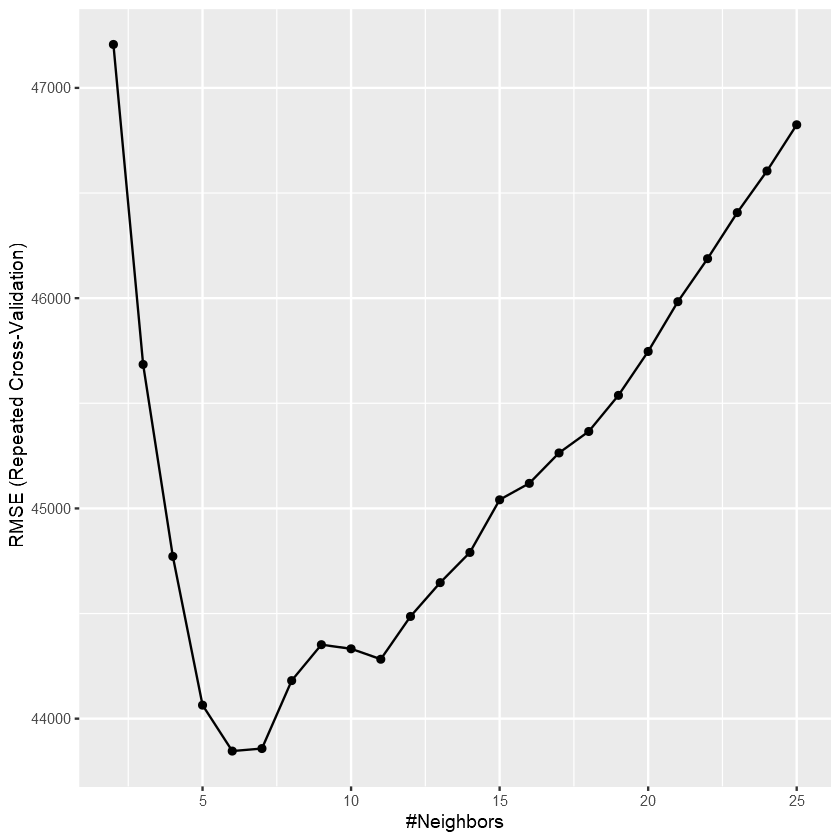

In [109]:
ggplot(knn_fit)